nota: questo progetto è stato eseguito su un dataset ridotto a soli 5000000 di transazioni rispetto all'originale.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
inputs= pd.read_csv("./dataset5000000/inputs.csv",names=['txid','prev_tx_id','prev_tx_pos'])
outputs = pd.read_csv("./dataset5000000/outputs.csv",names=['txid','position','address_id','amount','script_type'])
outputs=outputs.astype({
    'script_type':'uint8',
})
transactions = pd.read_csv("./dataset5000000/transactions.csv",names=['timestamp','block_id','txid','is_coinbase','fee'])
transactions= transactions.astype({
    'is_coinbase':'bool',
    'timestamp':'datetime64[s]'
})
map=pd.read_csv("./dataset5000000/mapAddr2Ids8708820.csv",names=['hash','address_id'])
map.set_index('address_id')

,hash
address_id,
0,1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa
1,12c6DSiU4Rq3P4ZxziKxzrL5LmMBrzjrJX
2,1HLoD9E4SDFFPDiYfNYnkBLQ85Y51J3Zb1
3,1FvzCLoTPGANNjWoUo6jUGuAG3wg1w4YjR
4,15ubicBBWFnvoZLT7GiU2qxjRaKJPdkDMG
...,...
8708816,13dJEWNK55L5Zbh8ZVqpvmpritkEYHD1nE
8708817,1GA1vXcj4UMwcgr7nBftkpxXE6RrBwwm2M
8708818,1DrJbVsNJDweTQgKAwrBNyKuvtFBS6iKNK


# 2.1 Analisi generali dei dati della blockchain

## distribuzione transazioni per blocco
distribuzione del numero di transazioni per blocco (occupazione del blocco), nell’intero
periodo temporale considerato

     transactions  blocks
50             51     389
51             52     382
52             53     409
53             54     395
54             55     377
..            ...     ...
847          1238       1
848          1283       1
849          1300       1
850          1301       1
851          1322       1

[802 rows x 2 columns]


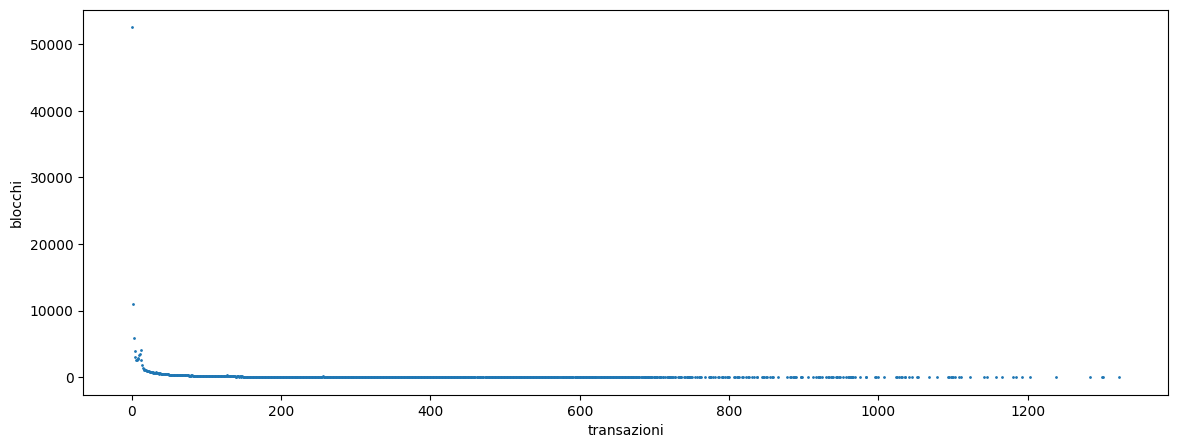

In [13]:
# conto il numero id transazioni per blocco
block_tx_count=transactions.groupby(['block_id']).count()[['timestamp','txid']]
block_tx_count.columns=['transactions','blocks']
#raggruppo in base al numero di transazioni e conto quanti blocchi possiedono un certo numero di transazioni
tx_blocks_distribution=block_tx_count.groupby('transactions',as_index=False).count()
tx_blocks_distribution.plot(kind='scatter',x='transactions',y='blocks',figsize=(14,5),s=1,xlabel='transazioni',ylabel='blocchi')
print(tx_blocks_distribution[50:])

come si puo notare abiamo tantissimi blocchi che possiedono 1 o 2 transazioni 

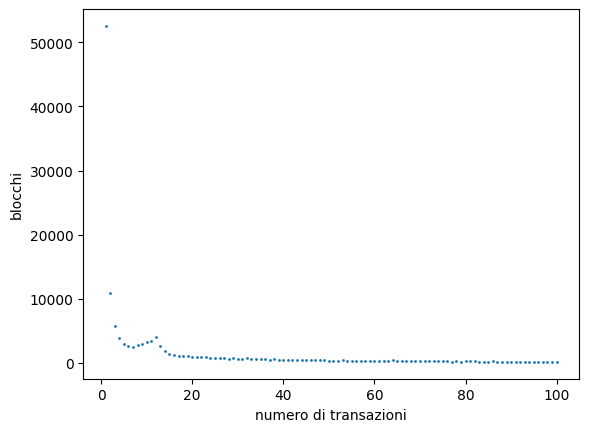

Con un piccolo zoom possiamo osservare meglio un piccolo fenomeno dove intorno alle 10 transazione si  tende ad avere una impennata del numero di blocchi fino a 4000 blocchi per transazione per poi cominciare a scendere.

## evoluzione dell'occupazione dei blocchi nel tempo
evoluzione dell'occupazione dei blocchi nel tempo, considerando intervalli temporali di due
mesi.(media dell'occupazione di blocchi su archi temporali di 2 mesi).

<AxesSubplot: ylabel='numero medio di transazioni per blocco'>

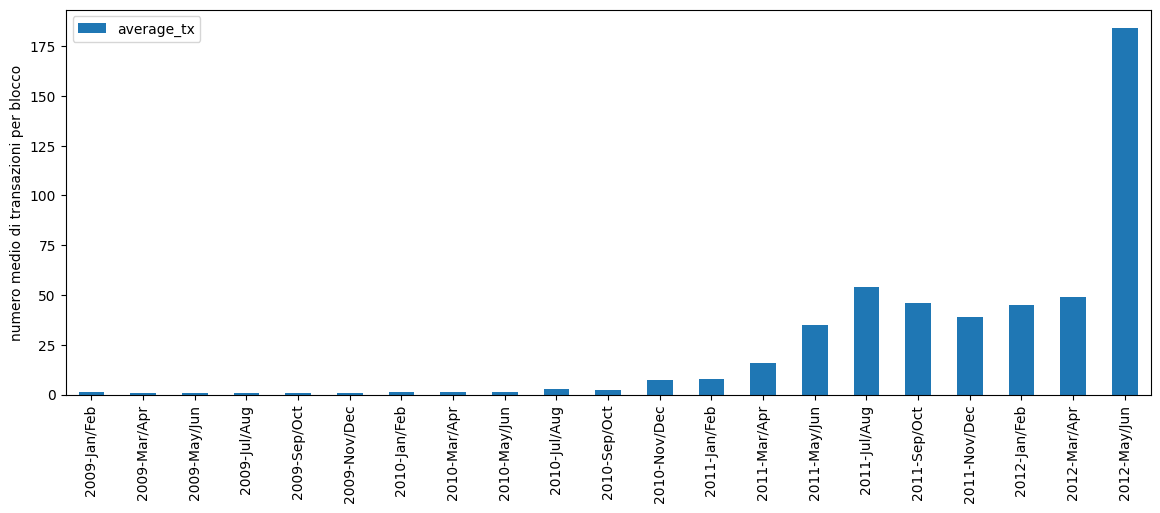

In [3]:
from itertools import pairwise
import calendar
# ragruppo le transazioni per anno e mese
month_group=transactions.groupby([transactions['timestamp'].dt.year,transactions['timestamp'].dt.month])
# dataframe finale che conterrà il risultato della query
average_tx=pd.DataFrame(columns=['average_tx'])
# uso questo iteratore per scorrere la chiavi dei gruppi 
keys_iterator=pairwise(month_group.groups.keys())
for (k1,k2) in keys_iterator:
    # fondo insieme i dataset per i mesi adiacenti
    months_df=pd.concat([month_group.get_group(k1),month_group.get_group(k2)])
    y,m1=k1
    _,m2=k2
    # conto il numero di transazioni per blocco ed effettuo la media
    average_tx.loc[f"{y}-{calendar.month_abbr[m1]}/{calendar.month_abbr[m2]}"]=months_df.groupby(['block_id']).count()['timestamp'].mean()
    _ = next(keys_iterator) # salta un elemento in modo da scorrere a coppie le chiavi

average_tx.plot.bar(figsize=(14,5),ylabel='numero medio di transazioni per blocco')

Fino ad ottobre 2010 notiamo una situazione motlto stabile con una media di 1-2 transazioni per blocco si ha una crescita ha molto rapida fino ad agosto 2011 ed infine dopo un lieve nelle transazioni medie si un picco improvviso a maggio-giugno 2012 fino a ragiungere le 184 transazioni medie per blocco

## ammontare degli ultimi UTXO rimanenti
ammontare totale degli UTXO al momento dell’ultima transazione registrata nella
blockchain considerata.

In [4]:
#associo ad ogno output l'input che lo spende , la somma totale del risultato della query mi dice l'ammontare degli output spesi
spent_utxos=outputs.merge(inputs,how='inner',left_on=['txid','position'],right_on=['prev_tx_id','prev_tx_pos'])
# effettuando la differenza con la somma totale di tutti gli outputs ottengo l'ammontare degli utxo 
unspent_utxos_amount=sum(outputs.amount)-sum(spent_utxos.amount)
print(f'il totale degli utxo esistenti ammonta a {unspent_utxos_amount}')

il totale degli utxo esistenti ammonta a 748652830914375


## durata media di un UTXO prima di essere speso
distribuzione degli intervalli di tempo che intercorrono tra la transazione che genera un
valore in output (UTXO) e quella che lo consuma, per gli output spesi nel periodo
considerato.

<AxesSubplot: xlabel='durata di un UTXO prima di essere speso in minuti', ylabel='numero di UTXO'>

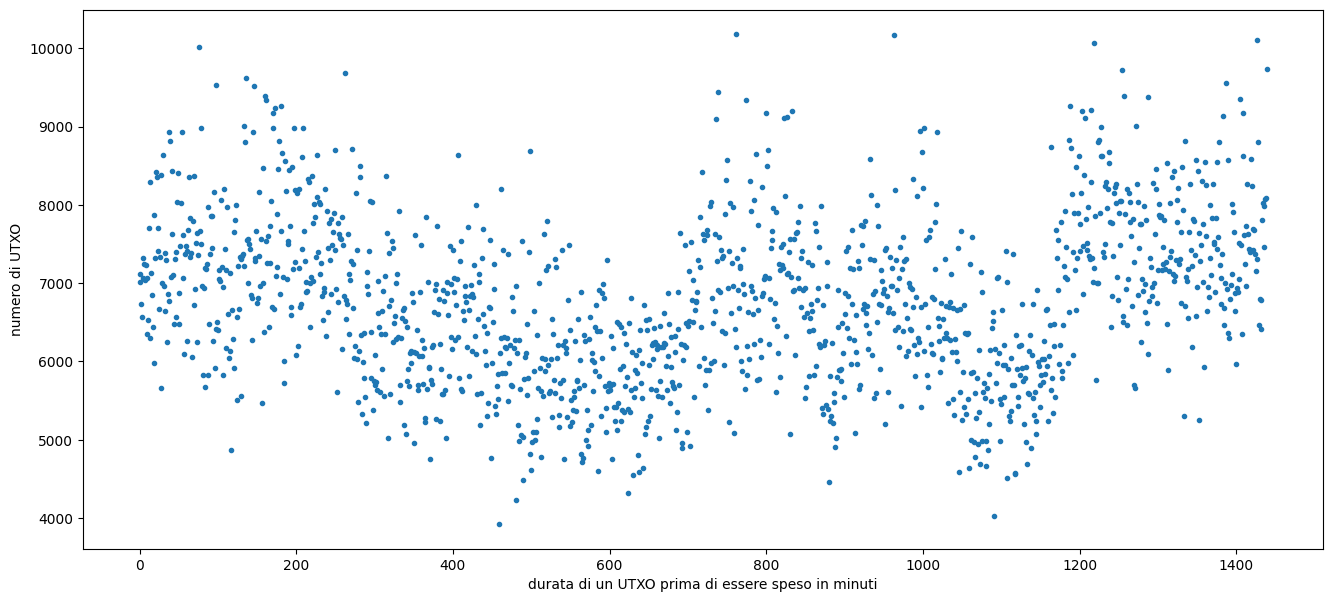

In [5]:
import math
# associo ad ogni input la transazione ed il corrispondente timestamp di quando è stato creato l'output riferito
created_tx_ts=inputs.merge(transactions[['txid','timestamp']],left_on='prev_tx_id',right_on='txid')
# associo ad ogni input la transazione ed il corrispondente timestamp di quando è stato speso l'output riferito
spent_tx_ts=inputs.merge(transactions[['txid','timestamp']],left_on='txid',right_on='txid')

average_utxo_dt=pd.DataFrame()
# calcolo la differenza fra quando è stato creato e quando è stato speso
# per questioni di leggiblita del grafico consideriamo la durata in minuti di una transazione
average_utxo_dt['deltatime']=np.floor(pd.to_timedelta(spent_tx_ts['timestamp']-created_tx_ts['timestamp'],unit='s').dt.seconds/60).astype(int)
# in base alla durata raggruppo gli utxo
average_utxo_dt=average_utxo_dt.groupby(['deltatime'],group_keys=True).apply(len) 
average_utxo_dt.plot(figsize=(16,7),style='.',xlabel='durata di un UTXO prima di essere speso in minuti',ylabel='numero di UTXO')

possiamo notare che UTXO tendono a durare non più di 24 ore prima di essere spesi, gli UTXO sono abbastanza eterogenei per quanto riguarda la durata.

## distribuzione del numero di input impiegati per le transazioni


<AxesSubplot: xlabel='numero di input (scala logaritmica)', ylabel='transazioni'>

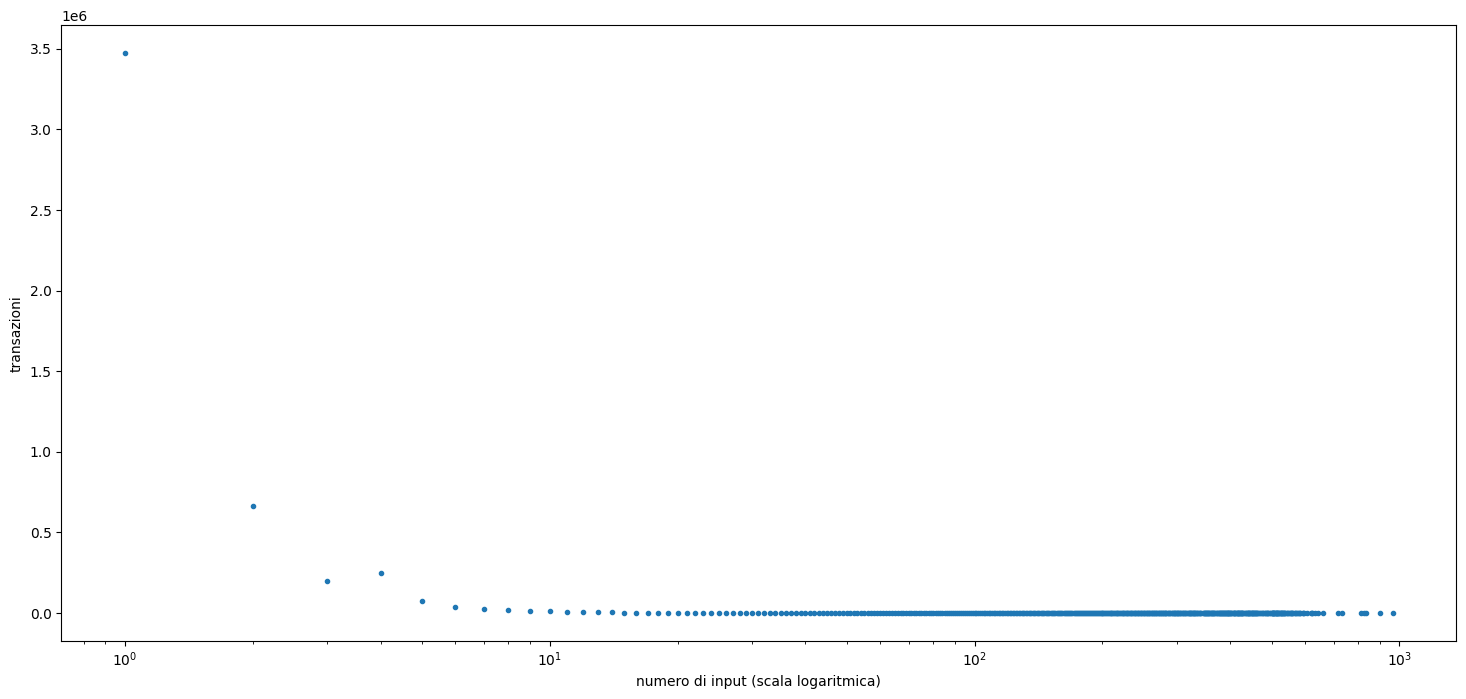

In [6]:
#conto gli input per transazione
input_count=inputs.groupby('txid').count()
input_count.columns=['inputs','transactions']
# ora che abbiamo associato ad ogni transazione il suo numero di input
# raggruppiamo per numero di input in modo da sapere quante transazioni hanno un certo numero di input
input_count=input_count.groupby('inputs').count()
input_count['transactions'].plot(style='.',figsize=(18,8),logx=True,xlabel='numero di input (scala logaritmica)',ylabel='transazioni')

possiamo osservare che abbiamo un numero elevato di transazioni con tantissimi input fino a 3.5 milioni , si avrà una discessa verso i 3 input dove si scende a circa 19000 blocchi con 3 input seguito da una piccola ripresa per 4 input a circa 25000 blocchi infine una discesa molto rapida verso 1 transazione con un certo numero di input.

# 2.2 clusterizzazione degli indirizzi di bitcoin


In [7]:
import networkx as nx
#associo ad ogni input l'output speso per  ottenere l'hash dell'indirizzo corrispondente
tx_addresses=inputs.merge(outputs,how='inner',left_on=['prev_tx_id','prev_tx_pos'],right_on=['txid','position'])[['txid_x','address_id']]
# ragruppo poi in base all transazione dell'input
tx_addresses=tx_addresses.groupby(['txid_x'])

In [8]:

from collections import defaultdict
g=nx.DiGraph()
# implementazione dell'algoritmo di clustering
for k,group in tx_addresses:
    if(len(group)<=1):# scarto i gruppi con un solo input
        continue
    # implementazione dell'euristica degli input
    # dove u è il primo indirizzo e v contiene il resto degli indirizzi
    u,*v=group['address_id'].to_list() 
    for _v in v:
        g.add_edge(map.loc[u].hash,map.loc[_v].hash)
#calcolo dei clusters
wcg=list(nx.weakly_connected_components(g))

first_ten_clusters=sorted(wcg,key=len,reverse=True)[0:10]


C:\Users\katyg\AppData\Local\Temp\ipykernel_2744\1554784151.py:4: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for k,group in tx_addresses:


numero di nodi 2368674
numero di archi 2464929
cluster più grande:191817
cluster più piccolo:1
dimensione media dei cluster:7.38664047151277
distribuzione della dimensione dei cluster:


<AxesSubplot: xlabel='dimensione cluster', ylabel='numero di cluster'>

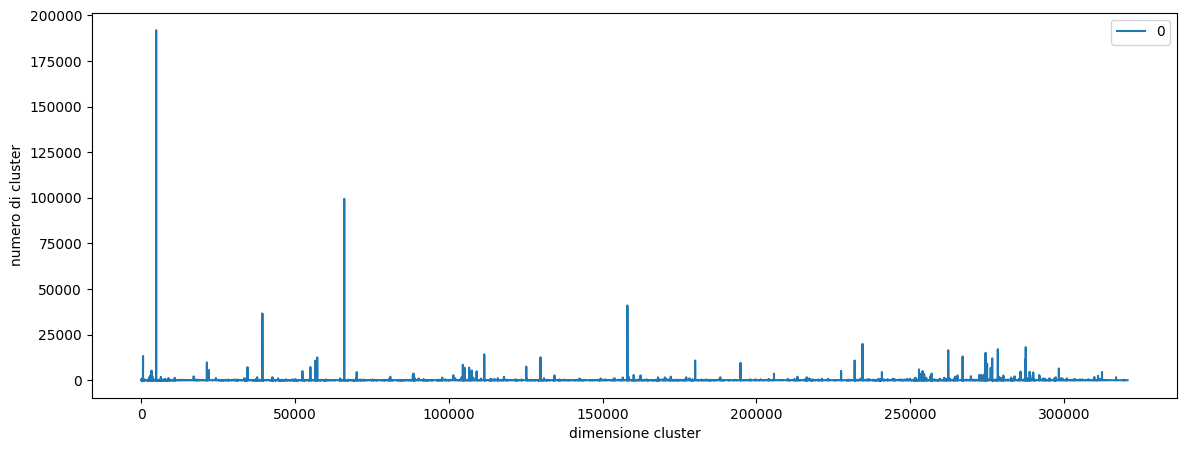

In [9]:
# calcolo statistiche varie
print(f"numero di nodi {g.number_of_nodes()}")
print(f"numero di archi {g.number_of_edges()}")
cluster_sizes=[ len(x) for x in wcg]
print(f"cluster più grande:{max(cluster_sizes)}")
print(f"cluster più piccolo:{min(cluster_sizes)}")
print(f"dimensione media dei cluster:{sum(cluster_sizes)/len(cluster_sizes)}")
cluster_stats=defaultdict(lambda:0)
# calcolo della distribuzione della dimensione dei cluster
for x in cluster_sizes:
    cluster_stats[x]+=1
print('distribuzione della dimensione dei cluster:')
pd.DataFrame(data=cluster_sizes).plot(figsize=(14,5),xlabel='dimensione cluster',ylabel='numero di cluster')

# deanonimizzazione


### scraping di wallet explorer

In [10]:
# wallet explorer
from bs4 import BeautifulSoup
import requests
from fp.fp import FreeProxy,FreeProxyException
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import WebDriverException
import undetected_chromedriver as uc
import time
from itertools import islice
#dizionario che contiene cluster deanonimizzati con il nome come chiave e gli indirizzi come valore
identity_dict=defaultdict(lambda:set())
request_delay=3# secondi da aspettare fra una richiesta e l'altra
max_tries=2# numero massimo di tentativi di deanonimizzazione per cluster
#scraping di wallet explorer
# la classe FreeProxy fornisce proxy funzionanti 
proxy=FreeProxy()
# indicizza le identità associate ai vari cluster
identity_list=[f'non deanonimizzato' for _ in range(0,10)]

print('inizio scraping wallet explorer')
for i,cluster in enumerate(first_ten_clusters):
    for address in islice(cluster,max_tries):
        time.sleep(request_delay)#distanzio le richieste per evitare un sovraccarico 
        # per evitare controlli anti-bot utilizzo un proxy in modo da non avere tante richieste da un solo ip
        try:#viene ricavato un proxy ad ogni nuovo tentativo 
            _proxy=proxy.get()
            # se l'oggetto FreeProxy non risce a trovare un proxy funzionante lancia l'eccezione FreeProxyException
        except FreeProxyException:
            _proxy={}
        # invio l'indirizzo richiesto nella richiesta get
        try:
            page=requests.get("https://www.walletexplorer.com/",{'q':address},proxies={'http':_proxy}).text
        except requests.exceptions.RequestException:
            continue
        bs = BeautifulSoup(page,'html.parser')
        wallet=bs.find('h2')
        # se il wallet non viene trovato o non è il nome di qualche servizio continua con la ricerca
        if wallet == None: 
            continue
        wallet=wallet.find_all(text=True)[1]
        if wallet[0]=='[':
            continue
        # in caso si arrivi a questo punto significa che è stato deanonimizzato un indirizzo percio assegnamo il cluster corrente 
        # al wallet identificato e si passa al prossimo cluster di indirizzi
        
        print(f"deanonimizzato {wallet}")
        # viene usato un set per evitare il caso di indirizzi ripetuti
        # tramite il metodo union copro anche il caso in qui un più cluster vengono assegnati ad un solo wallet
        identity_dict[wallet]=identity_dict[wallet].union(cluster)
        identity_list[i]=wallet
        break
print('scraping di wallet explorer terminato')

for i in range(0,10):
    print(f'cluster n.{i+1} : {identity_list[i]} possiede {len(first_ten_clusters[i])} indirizzi')



inizio scraping wallet explorer


C:\Users\katyg\AppData\Local\Temp\ipykernel_2744\2111707344.py:42: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  wallet=wallet.find_all(text=True)[1]


deanonimizzato CoinJoinMess 
deanonimizzato Instawallet.org 
deanonimizzato SilkRoadMarketplace 
deanonimizzato BTC-e.com-old 
scraping di wallet explorer terminato
cluster n.1 : CoinJoinMess  possiede 191817 indirizzi
cluster n.2 : non deanonimizzato possiede 99379 indirizzi
cluster n.3 : non deanonimizzato possiede 40968 indirizzi
cluster n.4 : Instawallet.org  possiede 36585 indirizzi
cluster n.5 : non deanonimizzato possiede 19894 indirizzi
cluster n.6 : SilkRoadMarketplace  possiede 18118 indirizzi
cluster n.7 : non deanonimizzato possiede 16977 indirizzi
cluster n.8 : non deanonimizzato possiede 16446 indirizzi
cluster n.9 : non deanonimizzato possiede 15020 indirizzi
cluster n.10 : BTC-e.com-old  possiede 14192 indirizzi


### scraping di bit info charts


In [11]:
identity_dict=defaultdict(lambda:set())
request_delay=3
max_tries=2

# scraping di bitcoin info-charts
# utilizzo undetected_chromedriver per evitare captcha di cloudflare ed altri controlli antibot
driver=uc.Chrome()# versione patchata di web driver di chrome per aggirare controlli anti web scraping 
driver_options=driver.options
driver_options.add_argument('--headless')
driver.options=driver_options
wallet_css_selector=".table-striped > tbody:nth-child(1) > tr:nth-child(1) > td:nth-child(2) > small:nth-child(2) > a:nth-child(1)"
identity_list=[f'non deanonimizzato' for _ in range(0,10)]
for i,cluster in enumerate(first_ten_clusters):
    for address in islice(cluster,max_tries):
        # utilizzo i proxy con la stessa lgocia di wallet explorer
        try:
            driver_options.add_argument(f'--proxy-server={proxy.get()}')
            driver.options = driver_options
        except FreeProxyException:
            pass
        time.sleep(request_delay)
        #richiesta get all'indirizzo interessato
        driver.get(f"https://bitinfocharts.com/bitcoin/address/{address}")
        # recupero del nome del wallet tramite selettore css
        try:
            wallet= WebDriverWait(driver,10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR,wallet_css_selector))
            )
        except WebDriverException:
            continue
        # stessa logica usata con wallet explorer
        if wallet == None:
            continue
        wallet = wallet.text.split(' ')[1]
        if wallet.isnumeric():
            continue
        identity_dict[wallet]=identity_dict[wallet].union(cluster)
        identity_list[i]=wallet
        print(f'deanonimizzato {wallet}')
        break 
driver.quit()
print('scraping di bitcoin info charts terminato')
for i in range(0,10):
    print(f'cluster n.{i+1} : {identity_list[i]} possiede {len(first_ten_clusters[i])} indirizzi')

deanonimizzato F2Pool
deanonimizzato Instawallet.org
deanonimizzato SilkRoadMarketplace
deanonimizzato Eligius
scraping di bitcoin info charts terminato
cluster n.1 : F2Pool possiede 191817 indirizzi
cluster n.2 : non deanonimizzato possiede 99379 indirizzi
cluster n.3 : non deanonimizzato possiede 40968 indirizzi
cluster n.4 : Instawallet.org possiede 36585 indirizzi
cluster n.5 : non deanonimizzato possiede 19894 indirizzi
cluster n.6 : SilkRoadMarketplace possiede 18118 indirizzi
cluster n.7 : non deanonimizzato possiede 16977 indirizzi
cluster n.8 : non deanonimizzato possiede 16446 indirizzi
cluster n.9 : non deanonimizzato possiede 15020 indirizzi
cluster n.10 : Eligius possiede 14192 indirizzi


[Text(0, 0, '191817'),
 Text(0, 0, '99379'),
 Text(0, 0, '40968'),
 Text(0, 0, '36585'),
 Text(0, 0, '19894'),
 Text(0, 0, '18118'),
 Text(0, 0, '16977'),
 Text(0, 0, '16446'),
 Text(0, 0, '15020'),
 Text(0, 0, '14192')]

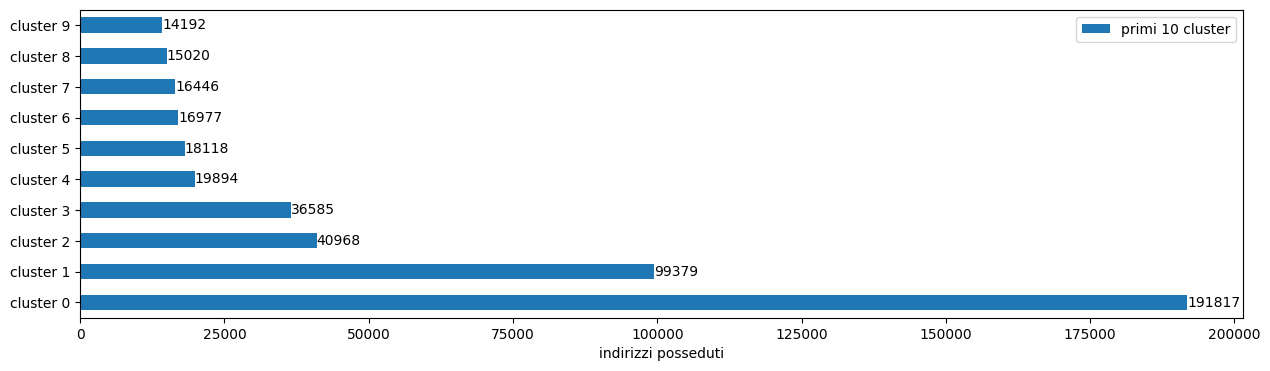

In [12]:
#dataframe che contiene i primi 10 cluster associati alla loro dimensione
identity_df=pd.DataFrame(data={'primi 10 cluster':{f'cluster {i}':len(g) for i,g in enumerate(first_ten_clusters)}})
bar_ax=identity_df.plot(kind='barh',xlabel='indirizzi posseduti',figsize=(15,4))
bar_ax.bar_label(bar_ax.containers[0])

dallo scraping di wallet explorer e bit info charts otteniamo i seguenti servizi associati ai primi 10 cluster:
- **CoinJoinMess** : questo wallet fa parte del servizio **Coin Join** è un servizio che si occupa di anonimizzare gli utenti che effettuano pagamenti in bitcoin,l'idea è di combinare più pagamenti appartenenti anche a più utenti in un solo grande pagamento in modo che sia difficile capire chi ha pagato cosa a terzi.
- **Instawallet** : è stato un __eWallet__ che in passato consentivia in modo anonimo di immagazzinare bitcoin ,è stato aperto nel 2011 e chiuso nel 2013.
- **SilkRoadMarketPlace** : famoso sito di e-commerce che consentiva l'acquisto di beni illegali di vario tipo ,è stato aperto nel 2011 e chiuso nel 2014.
- **BTC-e.com-old** : piattaforma di commercio aperta nel 2011 e chiusa nel 2017.
- **F2Pool** : pool di mining aperta dal 2013 e tutt'ora attiva.
- **Eligius** : mining pool aperta dal 2011 e tutt'ora attiva.

dopo aver eseguito un tentativo di scraping best-effort per cercare di deanonimizzare i cluster abbiamo ottenuto i seguenti risultati

| cluster | wallet explorer     | bit info charts     |
|---------|---------------------|---------------------|
| 1       | CoinJoinMess        | F2Pool              |
| 2       |                     |                     |
| 3       |                     |                     |
| 4       | InstaWallet.org     | Instawallet.org     |
| 5       |                     |                     |
| 6       | SilkRoadMarketPlace | SilkRoadMarketPlace |
| 7       |                     |                     |
| 8       |                     |                     |
| 9       |                     |                     |
| 10      | BTC-e.com-old       | Eligius             |

Come possiamo osservare alcuni cluster sono stati assegnati a wallet diversi:
questa discrepanza è probabilmente dovuta al fatto che wallet explorer utilizza un algoritmo di clusterizzazione ed assegnamento degli address ai wallet simile a quello implementato in questo progetto e bit info charts probabilmente utilizza un meccanismo diverso per associare nomi ai wallet.

Per il primo cluster in particolare possiamo dire che ha sicuramente influito il servizio coin join che è riuscito nel suo intento portando alla creazione di un gigantesco cluster associato al suo wallet anche se gli alcuni degli indirizzi presenti sono in realtà appartenenti ad altri servizi.

Molti servizi fra quelli deanonimizzati sono sono stati creati nel 2011 anno che coincide con un impennata delle transazioni medie per blocco come abbiamo visto in uno dei punti precedenti